<a href="https://colab.research.google.com/github/fragmento/Mod_4_-Andres_Mendel/blob/andres_chaves/Notebooks/Data_processing_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Chest x rays to identify Pneumonia

For this exercice we will be working with a dataset uploaded from Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

Let's explore the data.

In [0]:
#Basic uploads
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread #to read image from

import seaborn as sns
import os
%matplotlib inline


In [82]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 17 00:50:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    37W / 250W |   9161MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploring the Data

Original Data source:
Dataset containg three folders ['test', 'train', 'val']. Each folder contains 2 folders ['PNEUMONIA', 'NORMAL']. 

Number of Train samples : (3875, Pneumonia)(1341, Normla) - 5216

Number of Test samples: (390, Pneumonia)(234, Normla) - 624

Number of val samples: (8, Pneumonia)(8, Normla) - 16

In [0]:
path_to_data = '/content/drive/My Drive/Colab Notebooks/Mod_4_Andres_Mendel/Data/chest_xray'

In [5]:
# chequin what is inside the chest_xray directory
os.listdir(path_to_data)

['.DS_Store', 'val', 'train', 'test']

In [6]:
os.listdir(path_to_data+'/test')

['NORMAL', 'PNEUMONIA']

In [7]:
#Number of xrays with pneumonia in the test 
len(os.listdir(path_to_data+'/train/PNEUMONIA'))
#os.listdir(path_to_data+'/train/PNEUMONIA')

3875

In [8]:
#Number of normal xrays
len(os.listdir(path_to_data+'/train/NORMAL'))

1341

### Visualizing the data


In [108]:
#Getting the first normal/sick xray
normal_img_path = path_to_data+'/train/NORMAL'
os.listdir(normal_img_path)[2]

'IM-0511-0001-0001.jpeg'

In [109]:
sick_img_path = path_to_data+'/train/PNEUMONIA'
os.listdir(sick_img_path)[2]

'person583_bacteria_2408.jpeg'

In [0]:

norm_img = imread(normal_img_path+'/NORMAL2-IM-0927-0001.jpeg')
sick_img = imread(sick_img_path+'/person63_bacteria_306.jpeg')

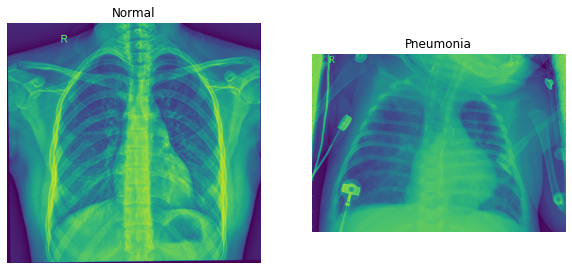

In [19]:
def pic_side_by_side(pic1, pic2, title1, title2):
    """
    Takes two pictures and two titles for them and outputs two pictures side by side
    """
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(pic1)
    ax1.set_title(title1)
    plt.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(pic2)
    ax2.set_title(title2)
    plt.axis('off');
    
pic_side_by_side(norm_img,sick_img,'Normal','Pneumonia')    

### Geting a sence of the diference in images sizes

In [20]:
norm_img.shape

(2234, 2359)

In [21]:
sick_img.shape

(736, 1048)

In [22]:
sick_img_path

'/content/drive/My Drive/Colab Notebooks/Mod_4_Andres_Mendel/Data/chest_xray/train/PNEUMONIA'

In [0]:
dim = []
for image_filename in os.listdir(sick_img_path):
    
    img = imread(sick_img_path+'/'+image_filename)
    dim.append(img.shape)

In [0]:
#dim

In [0]:
x_dim =[]
y_dim =[]
for img_tuple in dim:
    x_dim.append(img_tuple[0])
    y_dim.append(img_tuple[1])


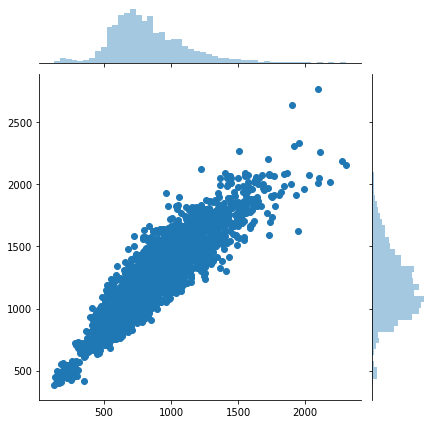

In [18]:
sns.jointplot(x_dim, y_dim);

In [19]:
#mean value for image size
np.mean(x_dim),np.mean(y_dim)

(825.0268387096775, 1200.4836129032258)

In [0]:
# image_shape = (800,1200)

### From RGB to Grayscale

From the exploration above image 14 is RGB type

In [24]:
os.listdir(sick_img_path)[14]

'person531_bacteria_2241.jpeg'

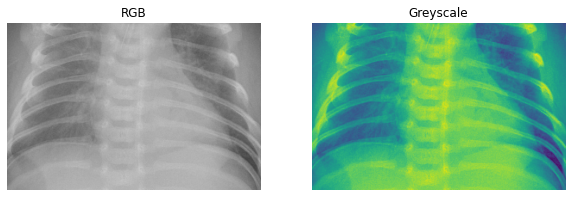

In [25]:
def rgb2gray(rgb):
    """
    Transforms RGB to Grayscale (x,y,colors) -> (x,y)
    """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = imread(sick_img_path+'/person69_bacteria_338.jpeg')     
grey = rgb2gray(img)    


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax1.set_title('RGB')
plt.axis('off')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(grey)
ax2.set_title('Greyscale')
plt.axis('off');

## Dataset preprocessing
Keras dataset preprocessing utilities, located at `tf.keras.preprocessing`, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

The data folder that looks like this:

`
Data/
   NORMAL/
      a_image_1.jpg
      a_image_2.jpg
   PNEUMONIA/
      b_image_1.jpg
      b_image_2.jpg
`      

### ImageDataGenerator
Generate batches of tensor image data with real-time data augmentation.

The data will be looped over (in batches).

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
tf.test.gpu_device_name()

'/device:GPU:0'

In [27]:
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
#exploring load_function
img2 = load_img(sick_img_path+'/'+ os.listdir(sick_img_path)[1290],
                                      color_mode="grayscale", 
                                      target_size=(256,256), interpolation="nearest")
type(img2)

img3 = load_img(normal_img_path+'/' +os.listdir(normal_img_path)[650],
                                      color_mode="grayscale", 
                                      target_size=(256,256), interpolation="nearest")

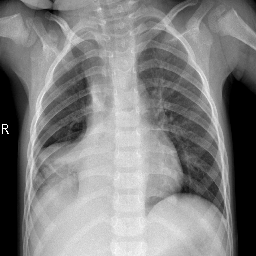

In [206]:
img2

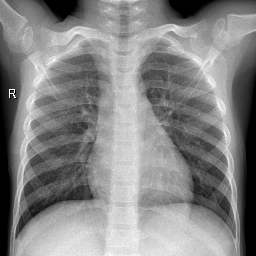

In [207]:
img3

In [30]:
#explorting img_to_array
img2 = img_to_array(img2)
img2.shape

(250, 250, 1)

In [0]:
#help(load_img)

In [0]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                               )

image_gen2 = ImageDataGenerator(rescale=1./255)

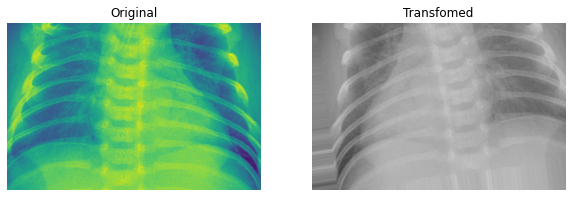

In [33]:
grey_new = image_gen.random_transform(img)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(grey)
ax1.set_title('Original')
plt.axis('off')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(grey_new)
ax2.set_title('Transfomed')
plt.axis('off');

In [34]:
#
image_gen.flow_from_directory(path_to_data+'/train')

Found 5216 images belonging to 2 classes.


In [35]:
image_gen.flow_from_directory(path_to_data+'/test')

Found 624 images belonging to 2 classes.


# Model

In [12]:
# Training the model
train_img = image_gen.flow_from_directory(path_to_data+'/train',
                                           color_mode='grayscale',
                                           batch_size=20,
                                           class_mode='binary')

test_img = image_gen2.flow_from_directory(path_to_data+'/test',
                                           color_mode='grayscale',
                                           batch_size=20,
                                           class_mode='binary')

# train_img = image_gen2.flow_from_directory(path_to_data+'/train',
#                                            batch_size=20)

# test_img = image_gen2.flow_from_directory(path_to_data+'/test',
#                                           batch_size=20)
                                           
                                      

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:
test_img.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Model architecture

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator


# Implementation of AlexNet Model

model = Sequential()

model.add(InputLayer( input_shape=(227, 227,3)))

#C1
model.add(Conv2D(64, (4, 4),strides=(3,3),padding='valid'))
model.add(Activation('relu'))
#P1
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))


#C2
model.add(Conv2D(128, (4, 4),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
#P2
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))

#C3
model.add(Conv2D(256, (3, 3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
#C4
model.add(Conv2D(256, (3, 3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
#C5
model.add(Conv2D(128, (3, 3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))

#P3
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
# the model so far outputs 3D feature maps (height, width, features)



model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

#1st fully connectd layer
model.add(Dense(128))
model.add(Activation('relu'))
#Dropout leyer
model.add(Dropout(0.5))

#2nd fully connectd layer
model.add(Dense(32))
model.add(Activation('relu'))
#Dropout leyer
model.add(Dropout(0.5))



model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=8)

In [257]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 75, 75, 64)        3136      
_________________________________________________________________
activation_135 (Activation)  (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 34, 34, 128)       131200    
_________________________________________________________________
activation_136 (Activation)  (None, 34, 34, 128)       0         
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 15, 15, 256)     

In [324]:
batch_size = 256
target_shape = (227,227)


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        path_to_data+'/train',  # this is the target directory
        target_size=target_shape,  # all images will be resized to 227x227
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data

validation_generator = test_datagen.flow_from_directory( 
        path_to_data+'/test',
        target_size=target_shape,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [263]:
model.fit_generator(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        verbose =1,
        workers = -1
        callbacks=[early_stop])
model.save_weights('alex_try_weights.h5')  # always save your weights after training or during training
model.save('alex_try.h5')

Epoch 1/50
21/21 [==============================] - 127s 6s/step - loss: 0.6054 - accuracy: 0.7370 - val_loss: 0.6870 - val_accuracy: 0.6250
Epoch 2/50
21/21 [==============================] - 126s 6s/step - loss: 0.5631 - accuracy: 0.7475 - val_loss: 0.7077 - val_accuracy: 0.6250
Epoch 3/50
21/21 [==============================] - 127s 6s/step - loss: 0.6038 - accuracy: 0.7387 - val_loss: 0.6644 - val_accuracy: 0.6250
Epoch 4/50
21/21 [==============================] - 126s 6s/step - loss: 0.5786 - accuracy: 0.7477 - val_loss: 0.6284 - val_accuracy: 0.6250
Epoch 5/50
21/21 [==============================] - 126s 6s/step - loss: 0.5653 - accuracy: 0.7362 - val_loss: 0.5698 - val_accuracy: 0.6250
Epoch 6/50
21/21 [==============================] - 125s 6s/step - loss: 0.4608 - accuracy: 0.7496 - val_loss: 0.5606 - val_accuracy: 0.6250
Epoch 7/50
21/21 [==============================] - 125s 6s/step - loss: 0.4039 - accuracy: 0.7801 - val_loss: 0.4603 - val_accuracy: 0.8013
Epoch 8/50
21

## Model Keras

In [0]:
history = pd.DataFrame(model.history.history)

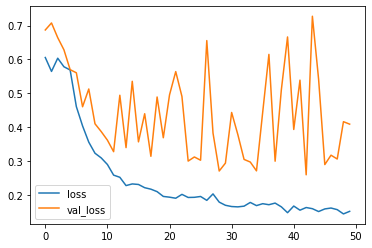

In [272]:
history[['loss', 'val_loss']].plot();

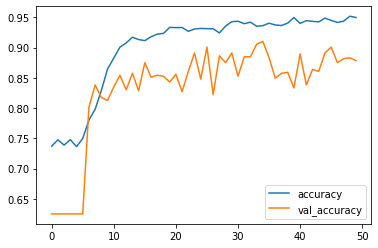

In [274]:
history[['accuracy', 'val_accuracy']].plot();

In [276]:
model.evaluate_generator(validation_generator)

[0.4089410603046417, 0.8782051205635071]

In [0]:
validation_generator.classes
df_classes = pd.DataFrame({'index1': validation_generator.index_array, 'classes': validation_generator.classes}, columns=['index1', 'classes'])

In [321]:
df_classes.sort_values(by=['index1'])
df_classes

,index1,classes
245,0,1
252,1,1
181,2,0
465,3,1
587,4,1
...,...,...
623,619,1
218,620,0
272,621,1
165,622,0


In [0]:
pred_prob = model.predict_generator(validation_generator)
pred_prob

In [325]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [334]:
prediction = pred_prob > 0.5
prediction

array([[False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [335]:
print(classification_report(validation_generator.classes,prediction))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       234
           1       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



In [336]:
confusion_matrix(validation_generator.classes,prediction)

array([[162,  72],
       [  4, 386]])